Import necessary libraries

In [1]:
import os
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torch import nn, optim
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
import itertools


Load the dataset and initialize transforms on images

In [2]:
dataset_path = "./train"
# Define transformations
data_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),  # Flip 50% of images
    transforms.RandomRotation(20),  # Rotate by 20 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust colors
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Random translations
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load dataset
dataset = ImageFolder(root=dataset_path, transform=data_transforms)
class_names = dataset.classes

Split dataset into 80-20 training and validation

In [3]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

Create Dataloaders

In [4]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

Plot images from dataset after transforms

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.67058825].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.4901961].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.88235295].
Clipping input data to the valid range for imshow

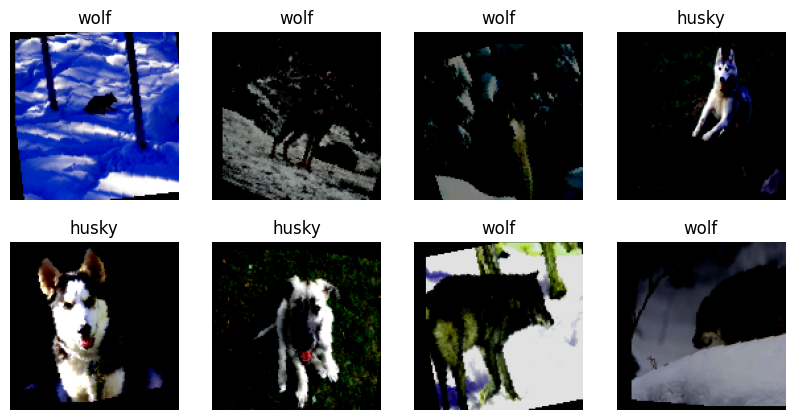

In [5]:
images, labels = next(iter(train_loader))
fig, axes = plt.subplots(2, 4, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    img = images[i].permute(1, 2, 0)  # Convert from Tensor format
    ax.imshow(img)
    ax.set_title(class_names[labels[i]])
    ax.axis("off")
plt.show()

Define a simple neural network classifier

In [6]:
class HuskyWolfClassifier(nn.Module):
    def __init__(self, hidden_size):
        super(HuskyWolfClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 128 * 3, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout layer (50%)
            nn.Linear(hidden_size, 2)
        )
    
    def forward(self, x):
        return self.model(x)


Hyperparameter tuning

In [7]:
hidden_sizes = [64, 128, 256]
learning_rates = [0.01, 0.001, 0.0001]
batch_sizes = [16, 32]

best_model = None
best_loss = float('inf')
best_params = {}
loss_history = []
accuracy_history = []


In [8]:
for hidden_size in hidden_sizes:
    for lr in learning_rates:
        for batch_size in batch_sizes:
            print(f"Training with hidden_size={hidden_size}, lr={lr}, batch_size={batch_size}")
            
            # Create DataLoaders with new batch size
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
            
            # Initialize model, loss, and optimizer
            model = HuskyWolfClassifier(hidden_size)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=lr)
            
            # Training loop
            epochs = 25
            for epoch in range(epochs):
                model.train()
                total_loss = 0
                for images, labels in train_loader:
                    optimizer.zero_grad()
                    outputs = model(images.view(images.shape[0], -1))
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
                    total_loss += loss.item()
                
                avg_loss = total_loss / len(train_loader)
                print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
                loss_history.append(avg_loss)
            
            # Save best model
            if avg_loss < best_loss:
                best_loss = avg_loss
                best_model = model
                best_params = {'hidden_size': hidden_size, 'lr': lr, 'batch_size': batch_size}

print("Best parameters:", best_params)
print("Best loss:", best_loss)

Training with hidden_size=64, lr=0.01, batch_size=16
Epoch 1/25, Loss: 19.2048
Epoch 2/25, Loss: 18.7852
Epoch 3/25, Loss: 27.5080
Epoch 4/25, Loss: 8.9875
Epoch 5/25, Loss: 11.4850
Epoch 6/25, Loss: 13.7154
Epoch 7/25, Loss: 3.9619
Epoch 8/25, Loss: 4.9794
Epoch 9/25, Loss: 3.2971
Epoch 10/25, Loss: 3.5341
Epoch 11/25, Loss: 3.2113
Epoch 12/25, Loss: 0.3065
Epoch 13/25, Loss: 2.0296
Epoch 14/25, Loss: 2.9866
Epoch 15/25, Loss: 0.8442
Epoch 16/25, Loss: 2.2296
Epoch 17/25, Loss: 2.9899
Epoch 18/25, Loss: 1.9268
Epoch 19/25, Loss: 1.4311
Epoch 20/25, Loss: 0.5540
Epoch 21/25, Loss: 2.7735
Epoch 22/25, Loss: 1.3104
Epoch 23/25, Loss: 3.0251
Epoch 24/25, Loss: 3.5379
Epoch 25/25, Loss: 1.5775
Training with hidden_size=64, lr=0.01, batch_size=32
Epoch 1/25, Loss: 17.3809
Epoch 2/25, Loss: 17.6925
Epoch 3/25, Loss: 17.6214
Epoch 4/25, Loss: 5.8837
Epoch 5/25, Loss: 8.2037
Epoch 6/25, Loss: 3.2574
Epoch 7/25, Loss: 3.1453
Epoch 8/25, Loss: 8.1163
Epoch 9/25, Loss: 5.2563
Epoch 10/25, Loss: 6

Evaluate the best parameters found on the validation dataset

In [9]:
best_model.eval()
total_val_loss = 0
correct = 0
total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in val_loader:
        outputs = best_model(images.view(images.shape[0], -1))
        loss = criterion(outputs, labels)
        total_val_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        y_true.extend(labels.tolist())
        y_pred.extend(predicted.tolist())

avg_val_loss = total_val_loss / len(val_loader)
accuracy = correct / total

print("Validation Loss on Best Model:", avg_val_loss)
print("Validation Accuracy on Best Model:", accuracy * 100, "%")
accuracy_history.append(accuracy * 100)

Validation Loss on Best Model: 0.24859896302223206
Validation Accuracy on Best Model: 90.0 %


Plot loss curve

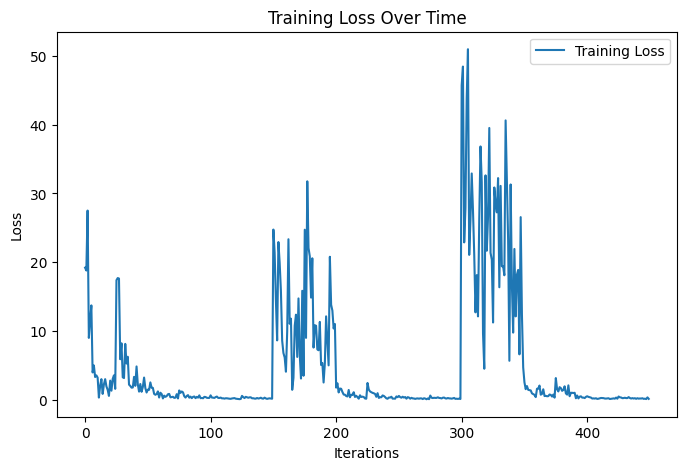

In [10]:
plt.figure(figsize=(8, 5))
plt.plot(loss_history, label='Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.show()

Plot confusion matrix

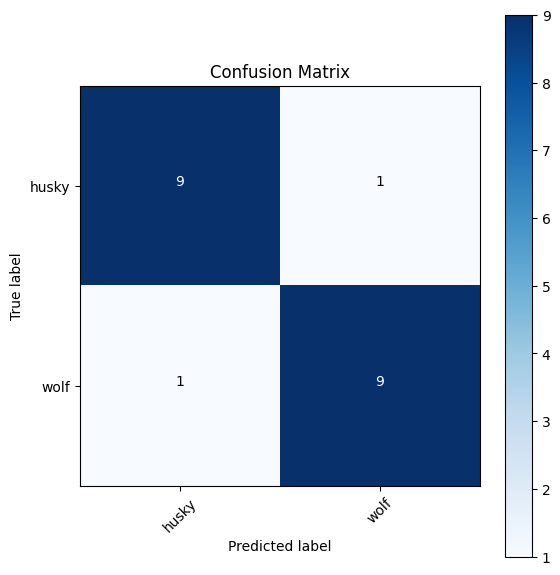

In [11]:
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, class_names)

Testing placeholder

In [12]:
test_path = 'path/to/test'
X_test, y_test = preprocess_images(test_path)
y_pred = make_predictions(X_test, best_model)
print(accuracy_score(y_test, y_pred))

NameError: name 'preprocess_images' is not defined